In [9]:
from matplotlib.pyplot import margins

from time2survive import policies_t2s, policies_t2s_std, policies_t2s_meds, policies_t2s_iqr
import matplotlib.pyplot as plt
import numpy as np


In [10]:
import pandas as pd
df = pd.read_csv("ECAI/db0_effrate0.4_we0_ECAI/db0_effrate0.4_we0_ECAI/t2s.csv")
nump = df.to_numpy()
medians = []
means = []
stds = []
iqr = []
for i in range(4):
    col = nump[:, i]
    col = col[col > 0]
    medians.append(np.median(col))
    iqr.append(np.percentile(col, 75) - np.percentile(col, 25))
    means.append(np.mean(col))
    stds.append(np.std(col))
    
print(means)
print(stds)
print(medians)
print(iqr)

[125.8734, 125.45, 455.6875, 408.21875]
[34.093808417951784, 33.26878867647574, 36.782670427118255, 62.17653012542193]
[120.0, 121.0, 470.5, 420.0]
[44.0, 42.0, 40.75, 121.5]


In [11]:
ag = 0
eff_rates = [0.2, 0.4, 0.6, 0.8]
db = [0, 10, 1000]
meds = np.array([policies_t2s_meds[eff_rate][s][ag] for eff_rate in eff_rates for s in db])
meds.shape

(12,)

In [12]:
eff_rates = [0.2, 0.4, 0.6, 0.8]
db = [0, 10, 1000]

# Step 1: Define your data (16 means and 16 stds)
meds = []
meds_eff = []
meds_ineff = []
iqr = []
iqr_eff = []
iqr_ineff = []
for eff_rate in eff_rates:
    for s in db:
        n = int(eff_rate * 5)
        meds.append(policies_t2s_meds[eff_rate][s].mean())
        meds_eff.append(policies_t2s_meds[eff_rate][s][:n].mean())
        meds_ineff.append(policies_t2s_meds[eff_rate][s][n:].mean())
        iqr.append(policies_t2s_iqr[eff_rate][s].mean())
        iqr_eff.append(policies_t2s_iqr[eff_rate][s][:n].mean())
        iqr_ineff.append(policies_t2s_iqr[eff_rate][s][n:].mean())


meds = np.array(meds)
meds_eff = np.array(meds_eff)
meds_ineff = np.array(meds_ineff)
iqr_eff = np.array(iqr_eff)
iqr_ineff = np.array(iqr_ineff)
iqr = np.array(iqr)

# Step 2: Define the x positions with separation between groups
x_positions = np.array([
    0, 1, 2,    # Group 1
    4, 5, 6,    # Group 2
    8, 9, 10, # Group 3
    12, 13, 14  # Group 4
])


x_labels = [
    'None', 'Low Capacity', 'High Capacity',    
]
x_labels = x_labels * 4
group_labels = ['Minority', 'Slight\nMinority', 'Slight\nMajority', 'Majority']

def plot_errorbar(data, data_err, title=""):
    for i in range(4):
        start = i * 3
        end = start + 3
        plt.errorbar(x_positions[start:end], data[start:end], yerr=data_err[start:end], fmt='-o', ecolor='gray', capsize=5, label=f"{group_labels[i]}")

    plt.xticks(x_positions, x_labels, rotation=45)
    plt.ylim(0, 500)
    # Add group labels below the individual labels
    for idx, group in enumerate(group_labels):
        # Calculate the position of the group label as the middle of the group's points
        group_pos = np.mean(x_positions[idx * 3:(idx + 1) * 3])
        #plt.text(group_pos, plt.ylim()[0] + 8.5, group, ha='center', va='top', fontsize=12, fontweight='bold')

    # Customize labels, title, and grid
    plt.xlabel('X Axis')
    plt.ylabel('Mean Values')
    plt.title(title)
    plt.grid(True)
    plt.legend()

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()


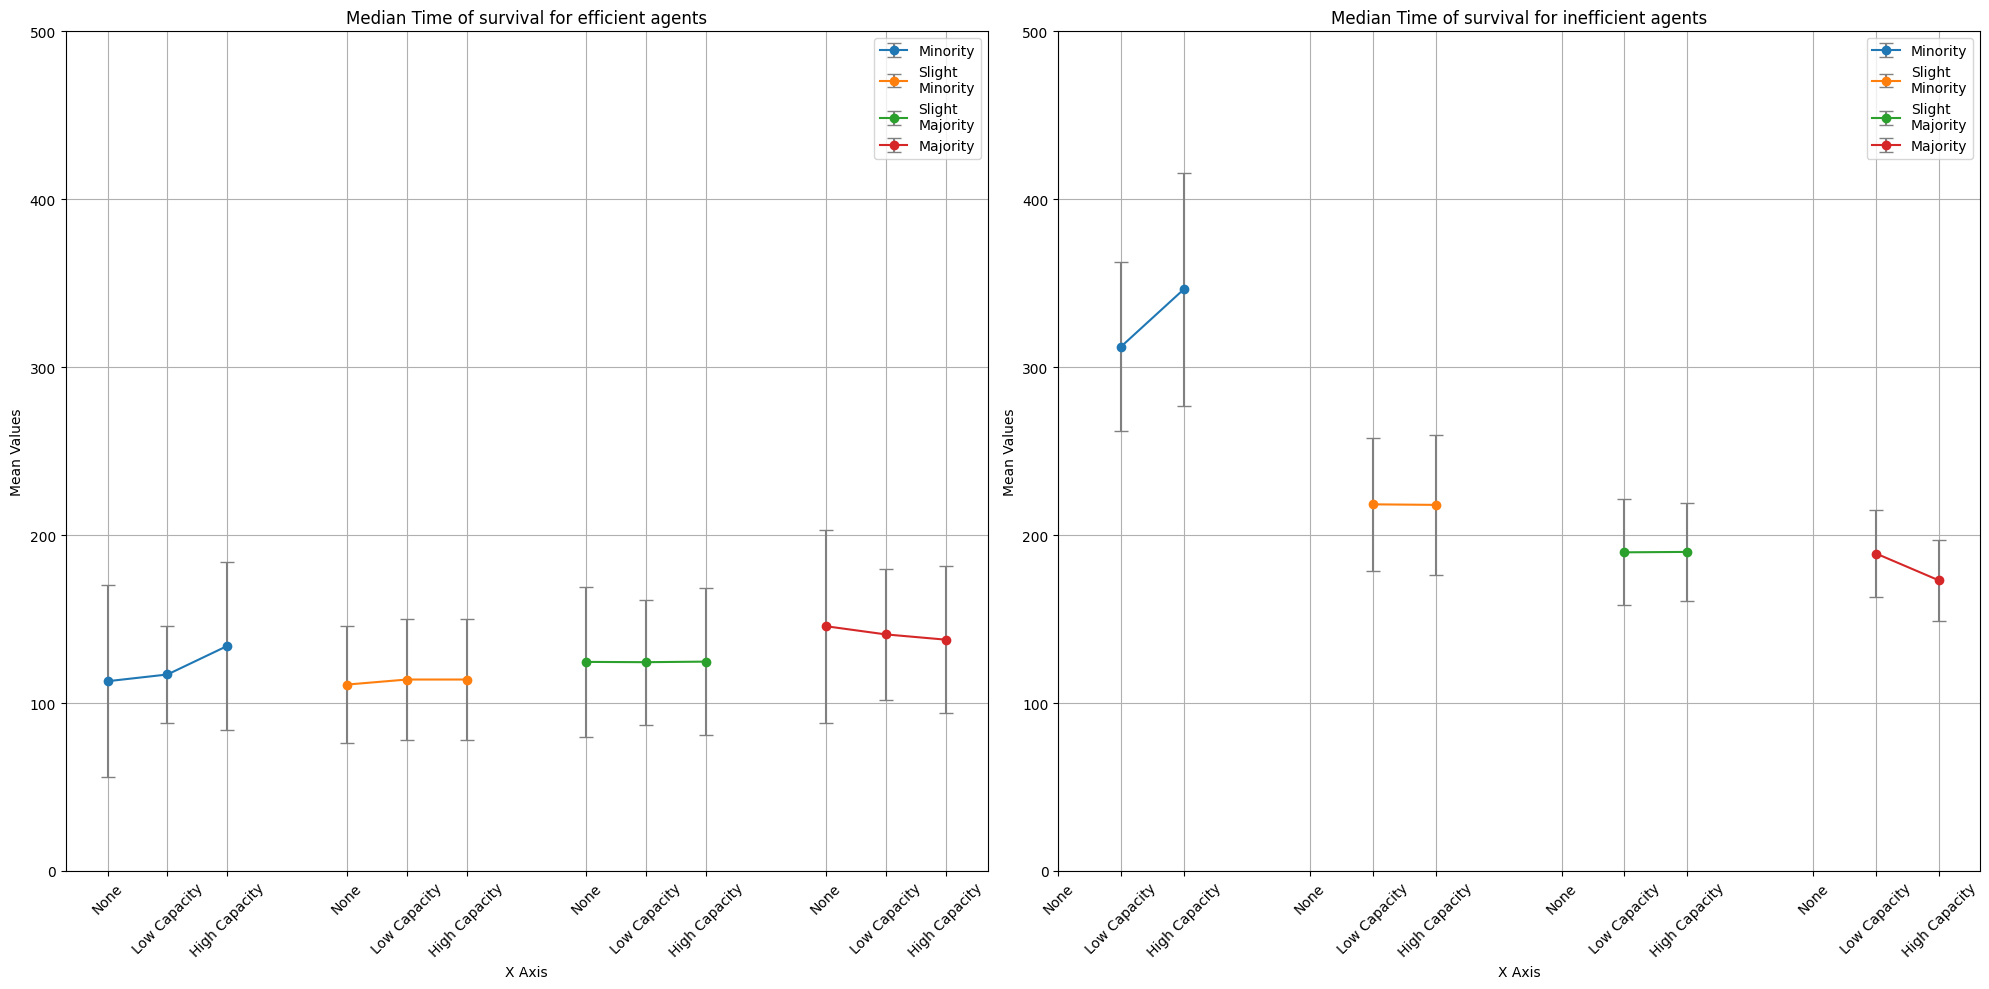

In [13]:
# Plot each group with error bars
ax, fig = plt.subplots(1, 2 , figsize=(20, 10))
plt.subplot(1, 2, 1)
# Plot each group with different colors
plot_errorbar(meds_eff, iqr_eff, title='Median Time of survival for efficient agents')

plt.subplot(1, 2, 2)
plot_errorbar(meds_ineff, iqr_ineff, title='Median Time of survival for inefficient agents')

# Show the plot
plt.show()

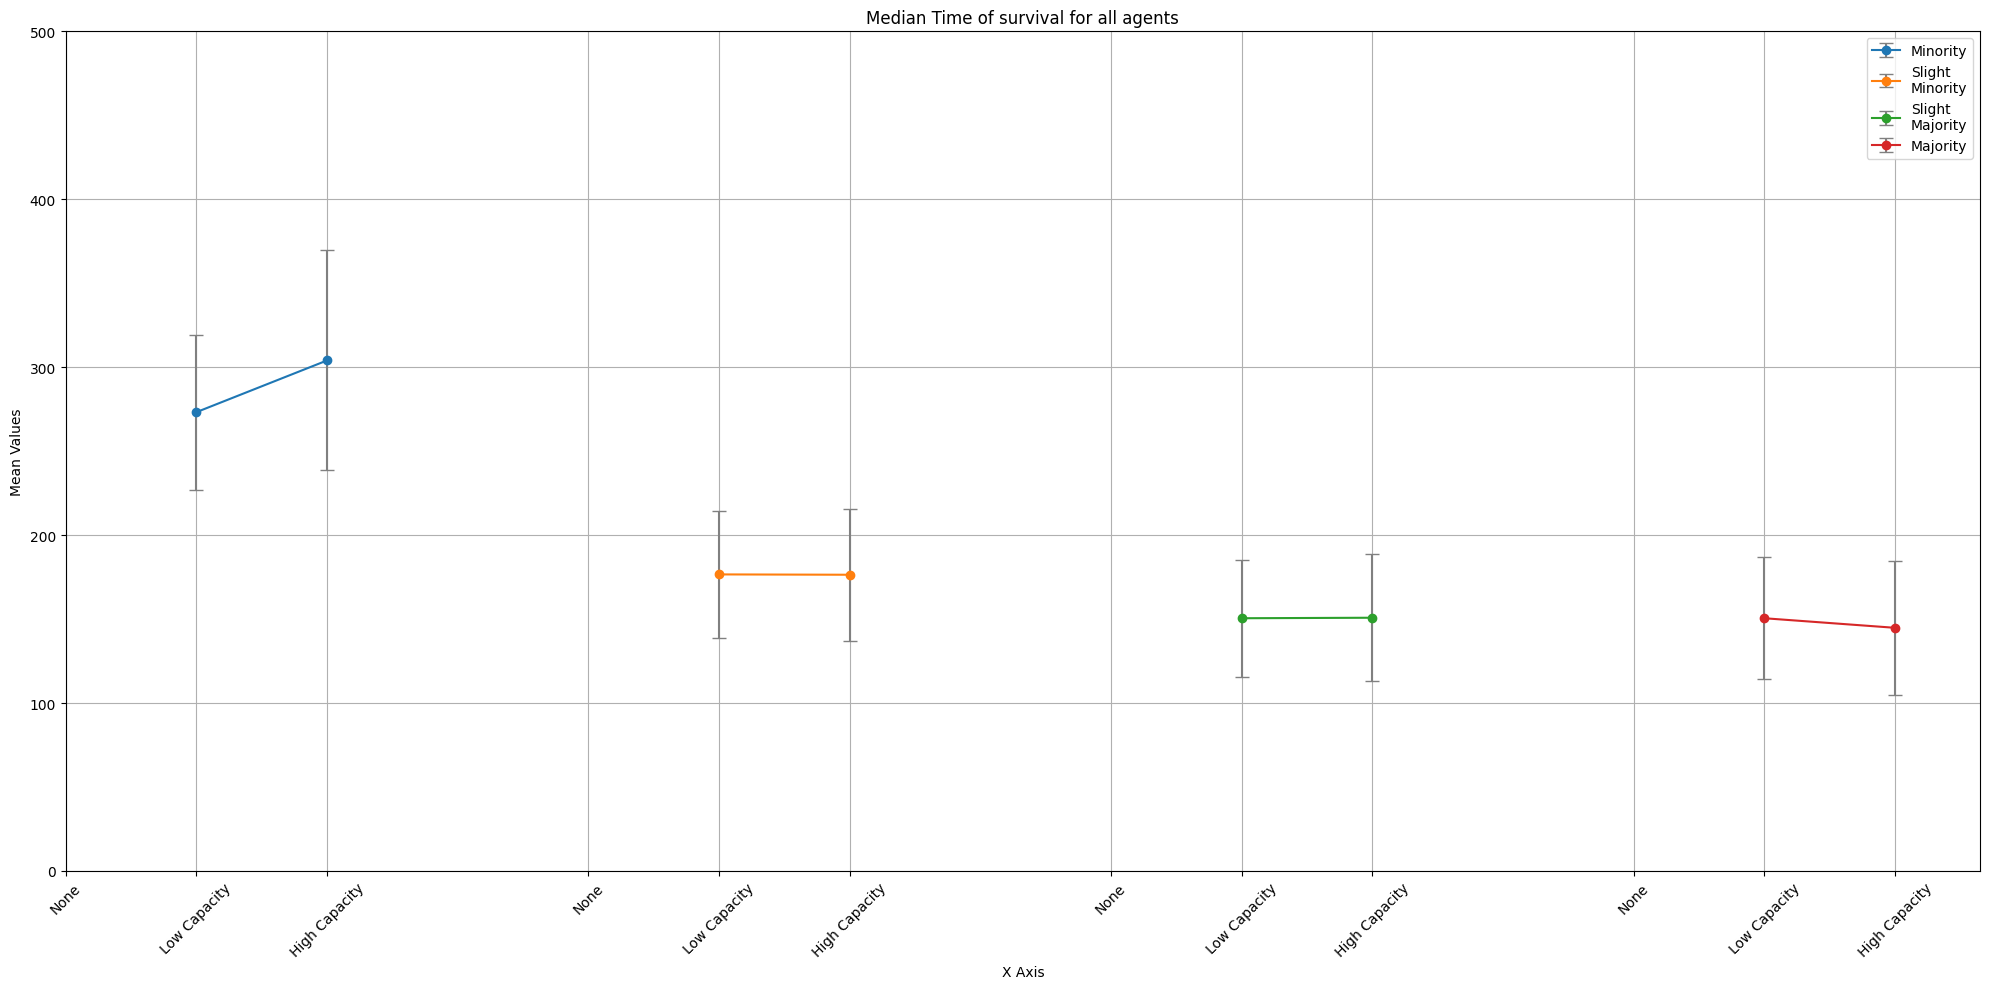

In [14]:
# Plot each group with error bars
plt.figure(figsize=(20, 10))

plot_errorbar(meds, iqr, title='Median Time of survival for all agents')

plt.show()

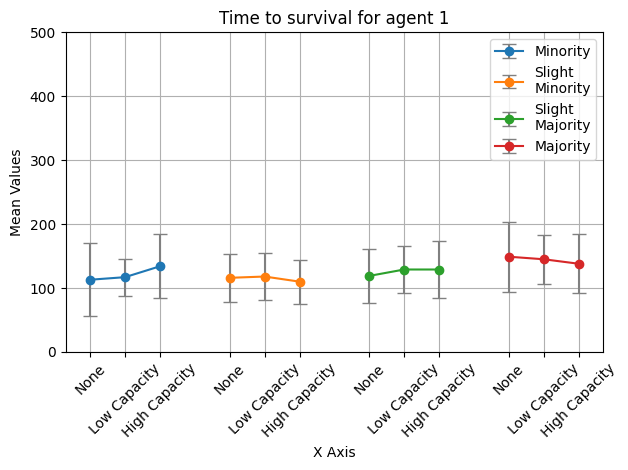

In [15]:
def plot_errorbar_per_agent(agent, title=""):
    colors = ["blue", "orange", "green", "red"]
    for i in range(4):
        start = i * 3
        end = start + 3
        vals = [policies_t2s_meds[eff_rates[i]][0][agent], policies_t2s_meds[eff_rates[i]][10][agent], policies_t2s_meds[eff_rates[i]][1000][agent]]
        errs = [policies_t2s_iqr[eff_rates[i]][0][agent], policies_t2s_iqr[eff_rates[i]][10][agent], policies_t2s_iqr[eff_rates[i]][1000][agent]]
        plt.errorbar(x_positions[start:end], vals, yerr=errs, fmt='-o', ecolor='gray', capsize=5, label=f"{group_labels[i]}")

    plt.xticks(x_positions, x_labels, rotation=45)
    plt.ylim(0, 500)

    # Customize labels, title, and grid
    plt.xlabel('X Axis')
    plt.ylabel('Mean Values')
    plt.title(f"Time to survival for agent {agent+1}")
    plt.grid(True)
    plt.legend()

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
    
plot_errorbar_per_agent(0)


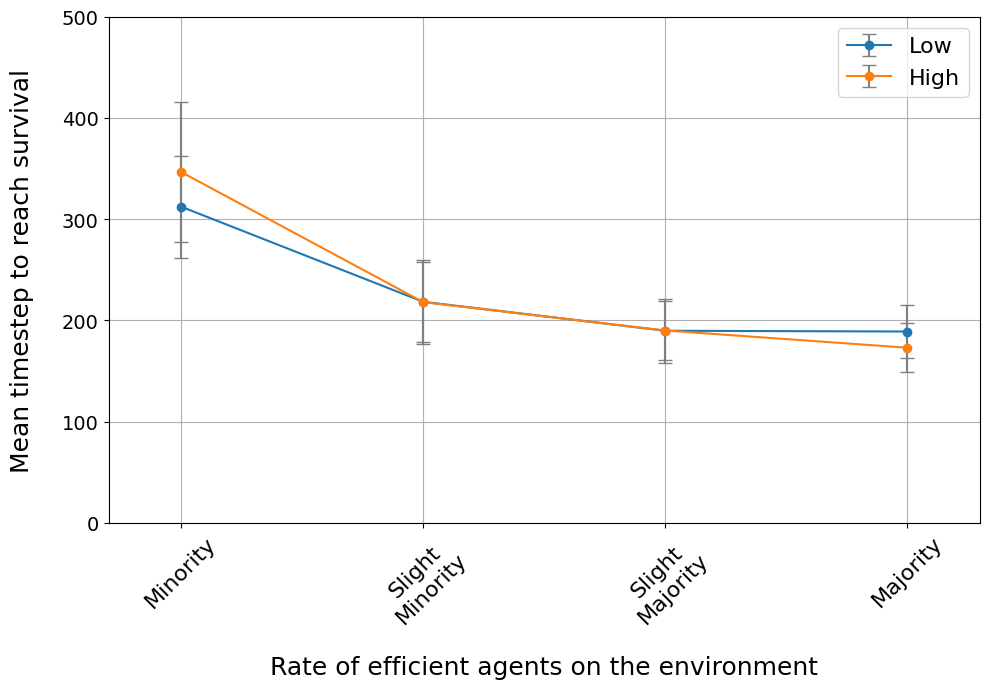

In [20]:
def plot_errorbar_ineff(db, title=""):
    vals = [policies_t2s_meds[eff_rates[i]][db][int(eff_rates[i] * 5):].mean() for i in range(4)]
    errs = [policies_t2s_iqr[eff_rates[i]][db][int(eff_rates[i] * 5):].mean() for i in range(4)]
    plt.errorbar([1,2,3,4], vals, yerr=errs, fmt='-o', ecolor='gray', capsize=5, label="Low" if db == 10 else "High")

    plt.xticks([1,2,3,4], group_labels, rotation=45, fontsize=16)
    plt.ylim(0, 500)
    plt.yticks(fontsize=14)

    # Customize labels, title, and grid
    plt.xlabel('Rate of efficient agents on the environment', fontsize=18, labelpad=20)
    plt.ylabel('Mean timestep to reach survival', fontsize=18, labelpad=20)
    plt.title(title, fontsize=22, pad=20)
    plt.margins(x=0.1)
    plt.grid(True)
    # Set legend as big
    plt.legend(fontsize=16)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
plt.figure(figsize=(10, 7))
plot_errorbar_ineff(10)
plot_errorbar_ineff(1000, "")